# Timing Analysis Demo

In [1]:
import avn.timing
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In this tutorial, we will be using AVN's timing module to look at the timing properties of a bird's songs. This module has both segmentation-dependent timing analysis methods, and segmentation-independent methods. To use the segmentation-dependent methods, you need to have segmented syllable data. This can be generated using AVN's segmentation module, or any other segmentation method of your choosing. Let's being with the segmentation-dependent methods

## Segmentation-dependent Timing Analysis

The first step of segmentation-dependent timing analysis is to load our syllable segmentations, and use them to instantiate a `SegmentTiming` object. This type of object has many built-in functions to perform out timing analysis. 

The syllable segmentations should be stored in a pandas dataframe with one row per syllable and the following columns:
- `files` should contain the name of the .wav file in which the syllable is found. 
- `onsets` should contain the onset timestamp of the syllable in seconds within the file. 
- `offsets` should contain the offset timestamp of the syllable in seconds within the file.

If your syllable dataframe has any additional columns (with notes or syllable type labels for example), that is completely fine and those will be preserved, and they will not affect the timing analysis results. 

Here is an example of what that segmentation table could look like: 

In [2]:
Bird_ID = 'G402'
path_to_syll_df = "../sample_data/" + Bird_ID + "_syll_df.csv"
syll_df = pd.read_csv(path_to_syll_df)
syll_df

,files,onsets,offsets,labels
0,G402_43362.23322048_9_19_6_28_42.wav,0.166009,0.225170,i
1,G402_43362.23322048_9_19_6_28_42.wav,0.321043,0.385828,i
2,G402_43362.23322048_9_19_6_28_42.wav,0.570295,0.626757,i
3,G402_43362.23322048_9_19_6_28_42.wav,0.690363,0.751837,i
4,G402_43362.23322048_9_19_6_28_42.wav,0.828390,0.898912,i
...,...,...,...,...
589,G402_43362.43586086_9_19_12_6_26.wav,1.808186,1.976712,b
590,G402_43362.43586086_9_19_12_6_26.wav,2.011905,2.095646,c
591,G402_43362.43586086_9_19_12_6_26.wav,2.114762,2.263175,d
592,G402_43362.43586086_9_19_12_6_26.wav,2.318934,2.402177,e


Note that the 'labels' column is not necessary, and will have no impact on the results of the timing analysis. 

Now let's create the `SegmentTiming` object by passing the Bird_ID and syll_df as inputs to `avn.timing.SegmentTiming()`, along with the path to the folder containing the song files in syll_df. 

In [3]:
segment_timing = avn.timing.SegmentTiming(Bird_ID, syll_df, song_folder_path='../sample_data/')

### Syllable Durations

We can use this new `segment_timing` object to get the distribution of syllable and gap durations in our segmentation table. To get the syllable durations, simply run:

In [4]:
syll_durations = segment_timing.get_syll_durations()
syll_durations.head(3)

,files,onsets,offsets,labels,durations
0,G402_43362.23322048_9_19_6_28_42.wav,0.166009,0.225170,i,0.059161
1,G402_43362.23322048_9_19_6_28_42.wav,0.321043,0.385828,i,0.064785
2,G402_43362.23322048_9_19_6_28_42.wav,0.570295,0.626757,i,0.056463


We can plot the distribution of syllable durations like so: 

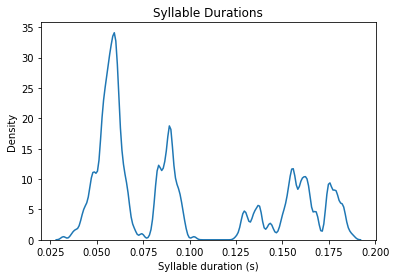

In [5]:
sns.kdeplot(data = syll_durations, x = 'durations', bw_adjust=0.1)
plt.title('Syllable Durations')
plt.xlabel('Syllable duration (s)');

This is an example of an adult zebra finch with quite stereotyped syllable durations. As a result, the syllable duration distribution is comprised of multiple narrow peaks, each reflecting a different syllable type. In contrast, juvenile birds producing subsong or birds with HVC lesions will have a single peak in their distribution with a long tail, reflecting the high variability of syllable durations in their songs. See [(Aronov et al. 2011)](https://www.jneurosci.org/content/31/45/16353) for more examples.

One way to quantify how 'peaky' (ie typical and mature) the syllable distribution is is to calculate the entropy of the distribution. This can be done by calling `segment_timing.calc_syll_duration_entropy()`. This entropy calculation is implemented according to the method described in [(Goldberg & Fee, 2011)](https://pubmed.ncbi.nlm.nih.gov/21430276/)

In [6]:
segment_timing.calc_syll_duration_entropy()

0.5838704938443375

The resulting entropy can range from 0 to 1, with higher scores indicating less predictable syllable durations, consistent with the songs of immature birds. 

### Gap Durations

We can also do the same for gap durations. By calling `segment_timing.get_gap_durations()`, AVN will calculate the duration of the silent gaps between all syllables in syll_df. Some of these gaps will be very long, reflecting the time between bouts or calls. Since we are only interested in the timing of song, it is recommended to ignore these longer gaps by specifying a maximum gap duration with the `max_gap` parameter. This should be set such that it is longer than any gaps between syllables in a bout, but is shorter tha the gaps between bouts. Here, we will use 0.2 seconds. 

In [7]:
gap_durations = segment_timing.get_gap_durations(max_gap = 0.2)
gap_durations.head(3)

,files,onsets,offsets,labels,durations
0,G402_43362.23322048_9_19_6_28_42.wav,0.000000,0.166009,silent_gap,0.166009
1,G402_43362.23322048_9_19_6_28_42.wav,0.225170,0.321043,silent_gap,0.095873
2,G402_43362.23322048_9_19_6_28_42.wav,0.385828,0.570295,silent_gap,0.184467


Now let's plot the gap duration distribution

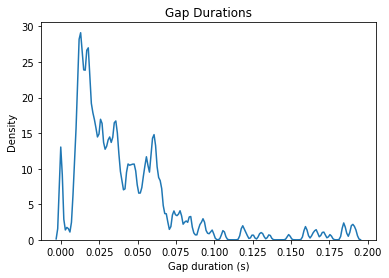

In [8]:
sns.kdeplot(data = gap_durations, x = 'durations', bw_adjust=0.1)
plt.title('Gap Durations')
plt.xlabel('Gap duration (s)');

We can also calculate the entropy of this distribution like so: 

In [9]:
segment_timing.calc_gap_duration_entropy()

0.8016231807294992

This value is calculated in the same way as the syllable duration entropy. 

## Segmentation-Independent Rhythm Analysis

In cases where we don't have reliable syllable segmentations, or when we wish to consider the timing of entire song bouts instead of individual syllables and gaps, we can use a "Rhythm Spectrum" approach based on [(Saar & Mitra, 2008)](https://pubmed.ncbi.nlm.nih.gov/18213370/). In AVN, this is done using the `RhythmAnalysis` class. You can create an instance of this class like so: 

In [10]:
rhythm_analysis = avn.timing.RhythmAnalysis(Bird_ID)

### The Rhythm Spectrogram

All these rhythm analyses center around the idea of a rhythm spectrum. This is the spectrum of the amplitude of a song. If the song's amplitude has consistent repeating fluctuation patterns (as we expect with multiple repetitions of a stereotyped motif), the spectrum will exhibit a harmonic banding pattern. If, by contrast, there are no repeating rhythms in the song's amplitude trace, the rhythm spectrum will have an even spread of magnitudes across frequency bands. This is the case for juvenile birds producing subsong. 

The rhythm spectrogram is a visual representation of the rhythm spectrum of multiple song files all concatenated to make the presence or absence and consistency of the harmonic bands across renditions more obvious. We can generate a rhythm spectrogram by calling `rhythm_analysis.make_rhythm_spectrogram()`, and specifying either:
-  `song_folder_path`: The path to a folder of .wav files to analyze. All .wav files in this folder will be included in the rhythm spectrogram
OR
- `song_files`: A list of .wav files to include. 

If both are specified the function will return an error, as the exact set of files to use is ambiguous. 

Let's specify the song_folder_path and look at all the files we have for our example bird: 

In [11]:
rhythm_spectrogram = rhythm_analysis.make_rhythm_spectrogram(song_folder_path='../sample_data/G402/', )

file is too short for the specified frame_length, n_windows and hop_length. File will be skipped.
file is too short for the specified frame_length, n_windows and hop_length. File will be skipped.


file is too short for the specified frame_length, n_windows and hop_length. File will be skipped.
file is too short for the specified frame_length, n_windows and hop_length. File will be skipped.
file is too short for the specified frame_length, n_windows and hop_length. File will be skipped.
file is too short for the specified frame_length, n_windows and hop_length. File will be skipped.
file is too short for the specified frame_length, n_windows and hop_length. File will be skipped.
file is too short for the specified frame_length, n_windows and hop_length. File will be skipped.
file is too short for the specified frame_length, n_windows and hop_length. File will be skipped.
file is too short for the specified frame_length, n_windows and hop_length. File will be skipped.
file is too short for the specified frame_length, n_windows and hop_length. File will be skipped.
file is too short for the specified frame_length, n_windows and hop_length. File will be skipped.
file is too short fo

A few of the files were skipped because they were too short. This is normal and can be ignored as long as there are enough files that are long enough. For more information about making the rhythm spectrogram, please refer to the function's docstring in the documentation tab. 

In addition to returning a copy of the rhythm spectrogram, the `rhythm_analysis.make_rhythm_spectrogram()` function also saves the rhythm spectrogram in `rhythm_analysis.rhythm_spectrogram`:

In [13]:
rhythm_analysis.rhythm_spectrogram

,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
30.000000,0.000176,0.000307,0.000286,0.000269,0.000144,0.000322,0.000172,0.000133,0.000261,0.000211,...,0.000184,0.000148,0.000092,0.000426,0.000300,0.000291,0.000260,0.000605,0.000359,0.000322
29.988975,0.000164,0.000313,0.000297,0.000271,0.000146,0.000320,0.000168,0.000127,0.000263,0.000217,...,0.000194,0.000144,0.000088,0.000429,0.000299,0.000284,0.000257,0.000606,0.000353,0.000320
29.977949,0.000153,0.000318,0.000308,0.000273,0.000150,0.000318,0.000163,0.000122,0.000264,0.000224,...,0.000204,0.000140,0.000091,0.000432,0.000298,0.000277,0.000255,0.000606,0.000346,0.000318
29.966924,0.000142,0.000323,0.000319,0.000274,0.000155,0.000317,0.000158,0.000117,0.000266,0.000230,...,0.000215,0.000136,0.000098,0.000434,0.000297,0.000271,0.000251,0.000607,0.000339,0.000316
29.955899,0.000132,0.000328,0.000329,0.000276,0.000160,0.000315,0.000154,0.000112,0.000267,0.000236,...,0.000225,0.000131,0.000107,0.000436,0.000295,0.000264,0.000248,0.000607,0.000332,0.000314
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0.055127,0.000053,0.000039,0.000053,0.000060,0.000074,0.000113,0.000075,0.000071,0.000026,0.000067,...,0.000070,0.000027,0.000045,0.000073,0.000068,0.000065,0.000083,0.000098,0.000063,0.000057
0.044101,0.000052,0.000038,0.000052,0.000060,0.000074,0.000112,0.000073,0.000071,0.000025,0.000067,...,0.000068,0.000025,0.000044,0.000071,0.000067,0.000065,0.000081,0.000098,0.000062,0.000055
0.033076,0.000050,0.000038,0.000052,0.000060,0.000073,0.000111,0.000072,0.000071,0.000025,0.000066,...,0.000067,0.000023,0.000043,0.000069,0.000067,0.000064,0.000080,0.000098,0.000061,0.000054
0.022051,0.000049,0.000038,0.000051,0.000060,0.000072,0.000111,0.000072,0.000071,0.000024,0.000066,...,0.000066,0.000022,0.000042,0.000068,0.000067,0.000063,0.000078,0.000098,0.000061,0.000053


Looking at the raw rhythm spectrogram table isn't very informative, so let's plot it instead: 

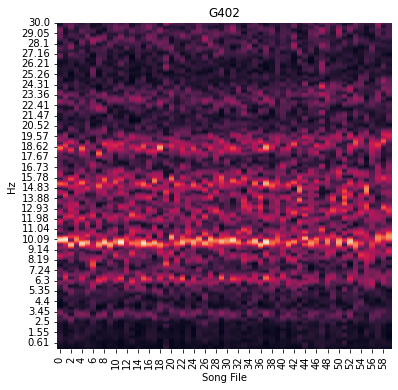

In [16]:
fig = rhythm_analysis.plot_rhythm_spectrogram()

There is some file-to-file variation in the spectra, but there does seem to be a consistent harmonic banding pattern present in this bird's rhythm spectrogram. These patterns can be easier to detect if we apply some smoothing along the song file dimension of the spectrogram. This can be done by setting a `smoothing_window` parameter when we make the plot. Let's try setting `smoothing_window=10`, which will plot the rolling average of 10 files rhythm spectra instead of a single spectrum per file: 

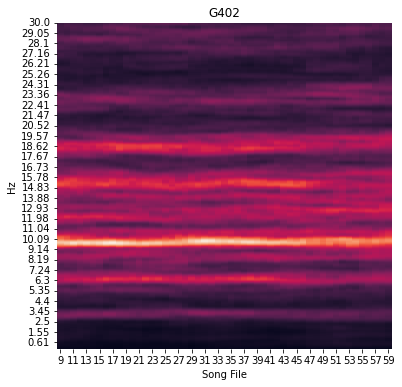

In [17]:
fig = rhythm_analysis.plot_rhythm_spectrogram(smoothing_window=10)

### Rhythm Spectrum Entropy

We can also quantify a bird's rhythmicity by calculating the Weiner Entropy of the mean rhythm spectrum across files. Weiner entropy is a feature implemented in the avn.acoustics module which can tess us how uniformly power is spread across frequency bands in the audio of a song. The value can range from 0 to negative infinity with noisy syllable having values closer to 0 and harmonic stacks having more negative values. 

 We can use this exact same idea to see how 'harmonic' the rhythm spectrum is. Once the rhythm spectrogram has been generated, we can calculate the Weiner entropy of the mean rhythm spectrum  like so:  

In [18]:
rhythm_analysis.calc_rhythm_spectrogram_entropy()

-0.4518114225775349

### Peak Frequency Variability

The exact spacing of the harmonics in a rhythm spectrogram depends on the shape of the amplitude trace of the bird's motif. It isn't obvious how different motifs and motif lengths affect the banding pattern of the rhythm spectrogram, so it doesn't make sense to compare the appearance of different birds rhythm spectra beyond the prominence of any harmonic bands. Likewise, the frequency of the harmonic with the highest magnitude also doesn't carry any special meaning. 

However, in a very stereotyped bird, that harmonic band with the highest frequency will be consistent across songs. If the bird sings its song slightly faster or slower the band can shift slightly in the frequency domain. So, another way to measure a bird's rhythm stereotypy is to look at the variability of the frequency with the highest magnitude across song files, aka the peak frequency. 

We can get a list of the peak frequency for each file by calling `rhythm_analysis.get_refined_peak_frequencies()`. We call this the *refined* peak frequency because this function actually finds the frequency with the highest magnitude for each file, then performs a second search for the peak frequency, this time restricted to the `freq_rage` band of frequencies centered on the overall median peak frequency. This is done to ensure that we are always comparing the frequency of the same harmonic band across files. If there are two or more harmonic bands of similar magnitude, the exact band with the highest magnitude can jump around unpredictably between the multiple bands, resulting in an overestimate of the variability. Refining our search by restricting it to a narrower band of frequencies can help us estimate the actual timing variability more reliably. 

In [19]:
peak_frequencies = rhythm_analysis.get_refined_peak_frequencies(freq_range=3)

Let's plot the refined peak frequencies over the rhythm spectrogram:

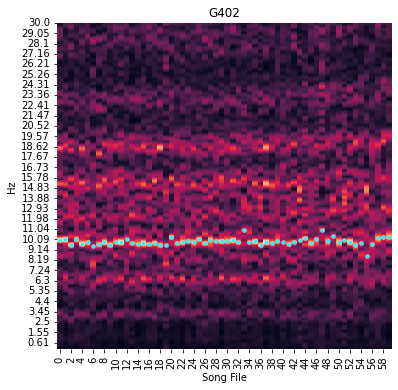

In [20]:
fig = rhythm_analysis.plot_peak_frequencies()

We can quantify the variability of the peak frequency by calculating it's coefficient of variability like so: 

In [21]:
rhythm_analysis.calc_peak_frequency_cv()

0.03378039097010725

And there you have it!